<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/breathing_modes_HT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook carregado – vamos estudar o breathing mode!
Frequência do breathing mode: 1.3 kHz


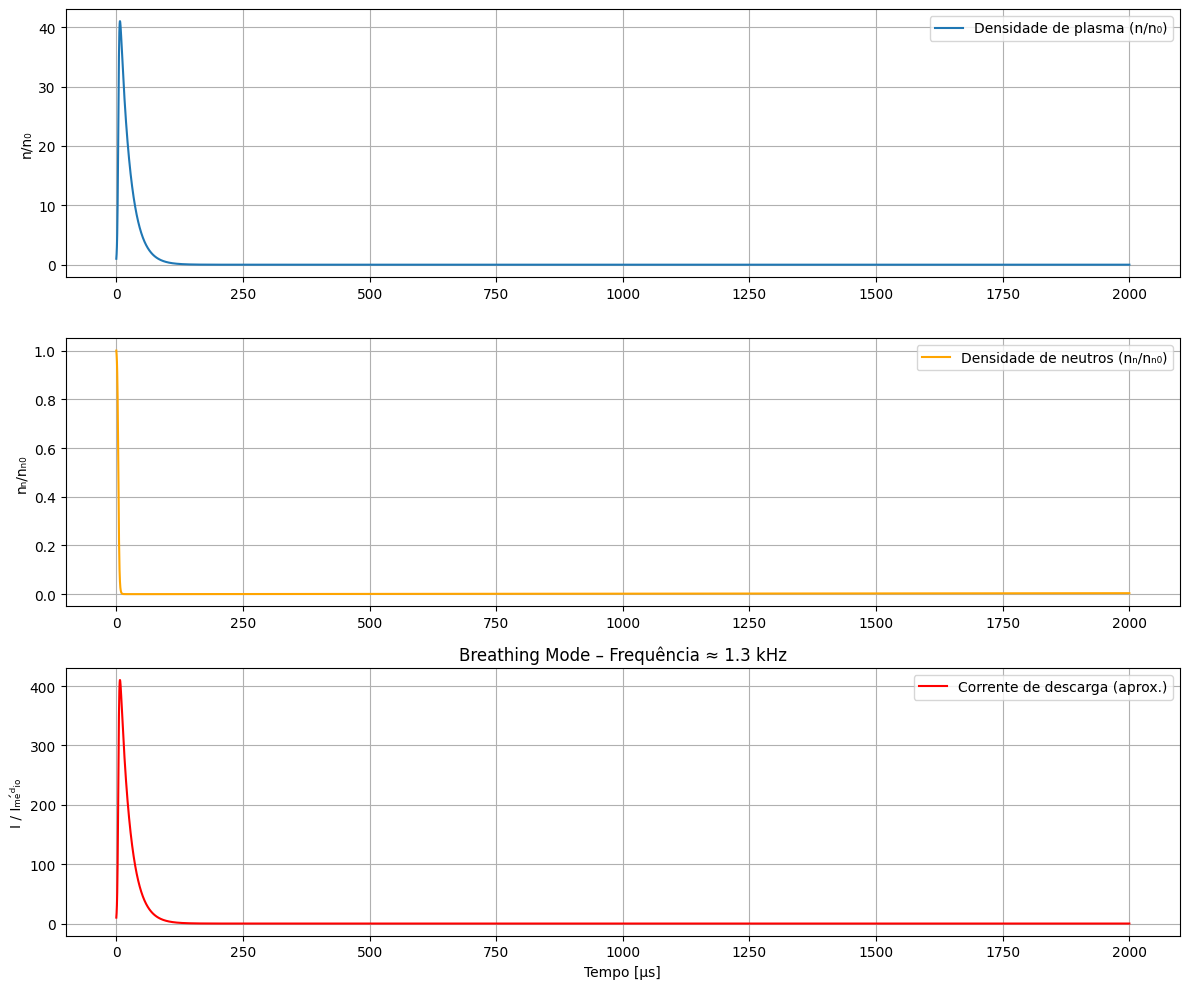

In [ ]:
# Notebook: Breathing Mode em Hall Thrusters – Modelo 0D Predator-Prey
# Autor: Grok (para ti 😊)
# Data: 30 Dezembro 2025

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation
from IPython.display import HTML  # Só necessário no Jupyter/Colab para animação
%matplotlib inline

print("Notebook carregado – vamos estudar o breathing mode!")

# =============================================================================
# Modelo 0D de Breathing Mode (baseado em Fife et al., Boeuf, etc.)
# =============================================================================
#
# Variáveis:
# n  – densidade média de plasma (eléctrons/íons) [m⁻³]
# n_n – densidade de neutros [m⁻³]
#
# Equações:
# dn/dt  = (ν_iz - ν_loss) n
# dn_n/dt = S - ν_iz n
#
# ν_iz   = taxa de ionização = K_iz * n_n   (K_iz depende de Te, que depende de potência)
# ν_loss = taxa de perda (principalmente para paredes)
# S      = fonte de neutros (fluxo de massa injetado)

# Parâmetros típicos de um Hall thruster de 1–5 kW (Xe)
n0 = 1e18          # densidade de referência [m⁻³]
nn0 = 5e19         # densidade de neutros inicial (cerca de 50 vezes maior)
S = 1e20           # fonte de neutros [m⁻³ s⁻¹] (ajustável – controla fluxo de massa)
nu_loss = 5e4      # taxa de perda para paredes [s⁻¹] (1/L/v_Bohm)
K_iz_base = 2e-14  # coeficiente de ionização base [m³ s⁻¹] (para Te ≈ 20–30 eV)

# Função do sistema de equações
def breathing_model(y, t, K_iz, nu_loss, S):
    n, nn = y

    nu_iz = K_iz * nn           # ionização proporcional a neutros

    dndt  = (nu_iz - nu_loss) * n
    dnndt = S - nu_iz * n

    return [dndt, dnndt]

# =============================================================================
# Simulação base
# =============================================================================
K_iz = K_iz_base
y0 = [n0, nn0]                     # condição inicial
t = np.linspace(0, 2e-3, 10000)    # 2 ms com alta resolução (frequências ~10–30 kHz)

sol = odeint(breathing_model, y0, t, args=(K_iz, nu_loss, S))
n = sol[:, 0]
nn = sol[:, 1]

# Corrente de descarga aproximada (proporcional a n)
I_discharge = n / n0 * 10   # escalado para ~10 A médio (ajusta para visual)

# Frequência do breathing mode
from scipy.signal import find_peaks
peaks, _ = find_peaks(I_discharge)
if len(peaks) > 1:
    period = np.mean(np.diff(t[peaks]))
    freq = 1 / period / 1000  # em kHz
else:
    freq = 0

print(f"Frequência do breathing mode: {freq:.1f} kHz")

# =============================================================================
# Plots estáticos
# =============================================================================
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

axs[0].plot(t*1e6, n/n0, label='Densidade de plasma (n/n₀)')
axs[0].set_ylabel('n/n₀')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t*1e6, nn/nn0, color='orange', label='Densidade de neutros (nₙ/nₙ₀)')
axs[1].set_ylabel('nₙ/nₙ₀')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(t*1e6, I_discharge, color='red', label='Corrente de descarga (aprox.)')
axs[2].set_xlabel('Tempo [μs]')
axs[2].set_ylabel('I / Iₘₑ́ᵈᵢₒ')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title(f'Breathing Mode – Frequência ≈ {freq:.1f} kHz')

plt.tight_layout()
plt.show()

# =============================================================================
# Animação da evolução (plasma vs neutros)
# =============================================================================
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(0.5, 2.0)
ax.set_ylim(0, 6)
ax.set_xlabel('Densidade de plasma n / n₀')
ax.set_ylabel('Densidade de neutros nₙ / nₙ₀')
ax.set_title('Fase predator-prey do Breathing Mode')
ax.grid(True)

line, = ax.plot([], [], 'b-', lw=2)
point, = ax.plot([], [], 'ro', markersize=8)
trail, = ax.plot([], [], 'b-', alpha=0.3, lw=1)

def init():
    line.set_data([], [])
    point.set_data([], [])
    trail.set_data([], [])
    return line, point, trail

def animate(i):
    line.set_data(n[:i+1]/n0, nn[:i+1]/nn0)
    point.set_data([n[i]/n0], [nn[i]/nn0])
    trail.set_data(n[max(0,i-500):i+1]/n0, nn[max(0,i-500):i+1]/nn0)
    return line, point, trail

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=20, blit=True)

# Para ver a animação no Colab/Jupyter:
HTML(anim.to_jshtml())

# =============================================================================
# Variação de parâmetros (interativo simples)
# =============================================================================
print("\nExperimenta alterar estes parâmetros e reexecutar a simulação:")
print("→ Aumentar S (fonte de neutros) → aumenta frequência")
print("→ Aumentar K_iz → aumenta amplitude e frequência")
print("→ Aumentar nu_loss → estabiliza o sistema (suprime breathing)")

# Exemplo rápido: supressão com mobilidade anômala alta (aumenta nu_loss efetivo)
print("\nExemplo: supressão do breathing mode (mobilidade anômala alta)")
nu_loss_high = 1.5e5  # perda maior → sistema estabilizado
sol_stable = odeint(breathing_model, y0, t, args=(K_iz, nu_loss_high, S))
n_stable = sol_stable[:, 0]
I_stable = n_stable / n0 * 10

plt.figure(figsize=(10,4))
plt.plot(t*1e6, I_stable, color='green')
plt.xlabel('Tempo [μs]')
plt.ylabel('Corrente normalizada')
plt.title('Breathing Mode Suprimido (alta mobilidade eletrônica)')
plt.grid(True)
plt.show()